In [ ]:
!pip install category_encoders

--2022-12-06 07:50:27--  https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/002/492/original/ola_driver_scaler.csv
Resolving d2beiqkhq929f0.cloudfront.net (d2beiqkhq929f0.cloudfront.net)... 99.84.170.176, 99.84.170.67, 99.84.170.112, ...
Connecting to d2beiqkhq929f0.cloudfront.net (d2beiqkhq929f0.cloudfront.net)|99.84.170.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1127673 (1.1M) [text/plain]
Saving to: ‘ola_driver_scaler.csv’

ola_driver_scaler.c 100%[===================>]   1.08M  4.14MB/s    in 0.3s    

2022-12-06 07:50:27 (4.14 MB/s) - ‘ola_driver_scaler.csv’ saved [1127673/1127673]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 72 kB 854 kB/s 


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from tabulate import tabulate
from scipy.stats import iqr
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from category_encoders import TargetEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier

In [ ]:
df = pd.read_csv('driver_data.csv', infer_datetime_format=False, index_col = 'Unnamed: 0', skip_blank_lines=True)

In [ ]:
df.head()

,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,01/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,2381060,2
1,02/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,-665480,2
2,03/01/19,1,28.0,0.0,C23,2,57387,24/12/18,03/11/19,1,1,0,2
3,11/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1
4,12/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1


## Problem Statement:

Ola is ride sharing platform who onboards Drivers with cars as Freelancers and allows booking of rides and payment interfaces for the drivers through its app.

During the years 2019-2020, for which duration the data is given, OLA cars experienced attrition of drivers from the platform due to the Lockdown and other effects of Covid-19. This attrition has increased further in the last few years and has been leading to slower operations for OLA and it's customers as there are not enough rides.

Another major reason is, Freelance Drivers prefer switching over platforms from OLA to companies like Uber based on the revision in payment ratios or incentives from time to time.

Through the shared data, OLA is trying to build a system to predict if certain attributes of drivers make them quit the platform, if the system would be accurate enough then it can be used to incentivize drivers who are about to quit, so operations can be continued or further improved.

## Data Summary

In [ ]:
def detect_outliers(df, c):
  p1 = df[c].quantile(0.25)
  p2 = df[c].quantile(0.75)
  iq = iqr(df[c])
  mask = ((df[c]<(p1-1.5*iq)) & (df[c]>(p2+1.5*iq)))
  if mask.sum()<1:
    mask = ((df[c]>df[c].quantile(0.01)) & (df[c]<df[c].quantile(0.999)))
    dft = df[mask]
  else: dft = df[~mask]

  print(f'% of Outliers in {c}: ', 100.0*(df.shape[0]-dft.shape[0])/df.shape[0], end='\n\n')

  return dft

In [ ]:
def summarize_df(df: pd.DataFrame, treat_outliers=False):

  rows = df.shape[0]
  colnos = df.shape[1]
  print('No. of rows: ', rows, ', No of columns: ', colnos)

  dup = df.duplicated().sum()
  if dup>0:
    print('No. of duplicate rows detected: ', dup, end = '\n\n')

    df.drop_duplicates(inplace=True)
    print('Removed all duplicates', end='\n\n')

  elif dup==0:
    print('No duplicates in the dataset', end='\n\n')


  print('Columns with nan value percentages: ', end='\n\n')

  nan = df.isna().sum()
  print(100*nan[nan>0]/rows, end='\n\n')

  df.columns = [c.lower().replace(' ', '_') for c in df.columns]
  
  print('Datatypes of columns:', end='\n\n')

  tb = {'Datatype': [], 'unique_values': []}
  for c in df.columns:
    if 'date' in c or 'time' in c or 'timestamp' in c or 'mmm' in c:
      df[c] = pd.to_datetime(df[c])


    elif df[c].dtype=='float64' or df[c].dtype=='int64' :

      if df[c].nunique()>200:
        if treat_outliers==True:
          df = detect_outliers(df, c)
        else: 
          _ = detect_outliers(df,c)
    
    tb['Datatype'].append(df[c].dtype)
    tb['unique_values'].append(df[c].nunique())

  tb = pd.DataFrame(tb, index = df.columns)

  print(tabulate(tb, headers = 'keys', tablefmt = 'psql'), end = '\n\n')

  print('Descriptive Stats: ', end='\n\n')
  print(tabulate(df.describe(include='all'), headers = 'keys', tablefmt = 'psql'))

  return df


In [ ]:
df = summarize_df(df)

No. of rows:  19104 , No of columns:  13
No duplicates in the dataset

Columns with nan value percentages: 

Age                 0.319305
Gender              0.272194
LastWorkingDate    91.541039
dtype: float64

Datatypes of columns:

% of Outliers in driver_id:  1.146356783919598

% of Outliers in income:  1.1306532663316582

% of Outliers in total_business_value:  34.903685092127304

+----------------------+----------------+-----------------+
|                      | Datatype       |   unique_values |
|----------------------+----------------+-----------------|
| mmm-yy               | datetime64[ns] |              24 |
| driver_id            | int64          |            2381 |
| age                  | float64        |              36 |
| gender               | float64        |               2 |
| city                 | object         |              29 |
| education_level      | int64          |               3 |
| income               | int64          |            2383 |
| dateofjoi

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.


## EDA

#### Univariate Analysis

In [ ]:
for c in df.columns:
  print(df[c].value_counts())

2019-01-01    1022
2019-02-01     944
2019-03-01     870
2020-12-01     819
2020-10-01     818
2020-08-01     812
2020-09-01     809
2020-07-01     806
2020-11-01     805
2019-12-01     795
2019-04-01     794
2020-01-01     782
2019-11-01     781
2020-06-01     770
2020-05-01     766
2019-05-01     764
2019-09-01     762
2020-02-01     761
2019-07-01     757
2019-08-01     754
2019-10-01     739
2020-04-01     729
2019-06-01     726
2020-03-01     719
Name: mmm-yy, dtype: int64
2110    24
2617    24
1623    24
1642    24
1644    24
        ..
1614     1
445      1
2397     1
1619     1
469      1
Name: driver_id, Length: 2381, dtype: int64
36.0    1283
33.0    1250
34.0    1234
30.0    1146
32.0    1143
35.0    1138
31.0    1076
29.0    1013
37.0     862
38.0     854
39.0     788
28.0     772
27.0     744
40.0     701
41.0     661
26.0     566
42.0     478
25.0     449
44.0     407
43.0     399
45.0     371
46.0     350
24.0     274
47.0     224
23.0     193
48.0     144
49.0      99
2

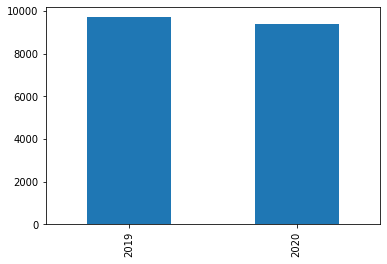

In [ ]:
df['mmm-yy'].dt.year.value_counts().plot(kind='bar')
plt.show()

The provided data includes datapoints only from 2019 and 2020 in almost equal distributions. 

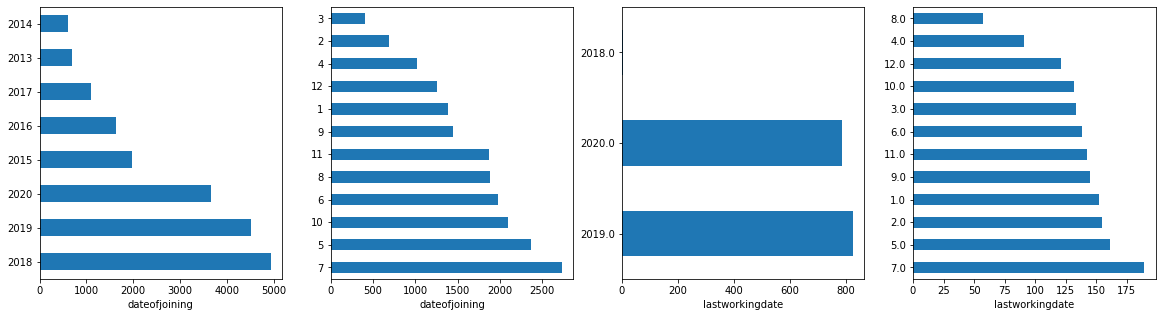

In [ ]:
cols = ['dateofjoining', 'lastworkingdate']
plt.figure(figsize=(20,5))
for i, c in enumerate(cols):
  if i==1: i=2
  plt.subplot(1,4,i+1)
  df[c].dt.year.value_counts().plot(kind='barh')
  plt.xlabel(c)
  plt.subplot(1,4,i+2)
  df[c].dt.month.value_counts().plot(kind='barh')
  plt.xlabel(c)
plt.show()

1. Majority of drivers joined the platform in 2018-2020 time period.
2. The most common months of joining are July and May.
3. Drivers who left the platform are more likely to have left in 2019 or 2020 which were COVID affected years and they would not have got a lot of work.
4. As common with date of joining, July and May are common months of attrition.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

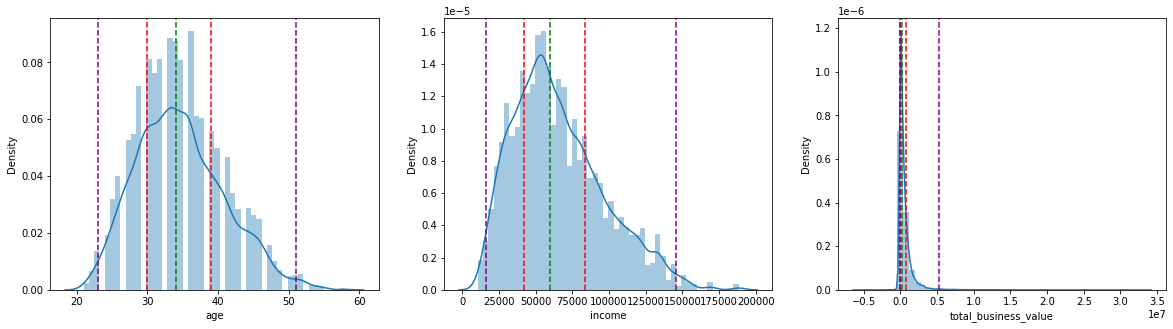

In [ ]:
cols = ['age', 'income', 'total_business_value']
plt.figure(figsize=(20,5))
for i,c in enumerate(cols):
  plt.subplot(1,3, i+1)
  sns.distplot(df[c])
  plt.axvline(df[c].quantile(0.25), ls='--', color='r')
  plt.axvline(df[c].quantile(0.75), ls='--', color='r')
  plt.axvline(df[c].quantile(0.5), ls='--', color='g')
  plt.axvline(df[c].quantile(0.01), ls='--', color='purple')
  plt.axvline(df[c].quantile(0.99), ls='--', color='purple')
plt.show()

1. 50% of drivers are in the age group of 30 to 40.

99% of drivers are in the age group of 22 to 52.

2. Around 50% of drivers earn between 45k to 80k per month. 99% of total earn 22k to 1.5L.

3. Alot of drivers are operating are break even for the company. Very few provide a business value that is upwards of 50k for the company. However, there are also drivers causing losses of upwards of 5L for the company. This could be an important feature that might be impacting the attrition of drivers.

### Imputing missing values

In [ ]:
#Imputing Nan values for age and genders based on driver_ids
cols = ['age', 'gender']
for c in cols:
  ind = df[df[c].isna()].index
  for index in ind:
    df[c][index] = df[df['driver_id']==df.iloc[index]['driver_id']][c].max()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
df.isna().sum()

mmm-yy                      0
driver_id                   0
age                         0
gender                      0
city                        0
education_level             0
income                      0
dateofjoining               0
lastworkingdate         17488
joining_designation         0
grade                       0
total_business_value        0
quarterly_rating            0
dtype: int64

Gender and age values have been imputed based on driver_ids

### Preparation for aggregation

In [ ]:
dfc = df.copy()

Now, creating a feature to mark business based profits and losses to the company for each driver

In [ ]:
loss = []
for i in range(len(df['total_business_value'])):
  if df['total_business_value'].iloc[i]<0:
    loss.append(df['total_business_value'].iloc[i])
    df['total_business_value'][i] = 0
  else: loss.append(0)

df.rename(columns = {'total_business_value':'total_profits'}, inplace=True)
df['total_losses'] = loss

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Preparing the data for aggregating based on driver_ids as there are unequal number of rows for each driver based on the data date ranges.

In [ ]:
df.sort_values(['driver_id', 'mmm-yy'], inplace=True)

Store quarterly rating change, grade_change and income changes based on dates for feature creations after aggregation.

Method-Groupby based on driver_ids, extract first values and last values in separate dataframes.

In [ ]:
lasts = dfc.groupby('driver_id').nth(-1).sort_values('driver_id', ignore_index=True)
firsts = dfc.groupby('driver_id').nth(0).sort_values('driver_id', ignore_index=True)

In [ ]:
quarterly_rating_change = lasts['quarterly_rating']-firsts['quarterly_rating']

In [ ]:
grade_change = lasts['grade']-firsts['grade']

In [ ]:
inc_change = lasts['income']-firsts['income']
inc_change[inc_change>0]=1

## Data Aggregation

Checking if a driver has more than 1 last working date

In [ ]:
verify = df[['driver_id','lastworkingdate']].value_counts()
verify[verify>1]

Series([], dtype: int64)

All drivers have only 1 lastworkingdates, so we can aggregate based on max value. This is probably due to driver_ids changing based on onboarding of the driver.

In [ ]:
df = df.groupby('driver_id', as_index=False).agg({'age': max, 'gender': max, 'city': min, 'education_level': max, 'income': max, 'dateofjoining': min, \
                                  'lastworkingdate': max, 'joining_designation':min, 'grade':max, 'total_profits': sum, 'total_losses': sum, 'quarterly_rating':max})

### Feature Creation

#### Creating the target variable

In [ ]:
df['attrition_status'] = (~df['lastworkingdate'].isna()).astype('int64')

#### Other Features

In [ ]:
df.sort_values('driver_id', inplace=True)

In [ ]:
#Creating features for change in Grade, quarterly rating and incomes of drivers based on their time periods with the company

df['grade_change'] = grade_change
df['inc_change'] = inc_change
df['rating_change'] = quarterly_rating_change

Create Feature: No.of Working days for the driver

The date of joining and last working date is provided for the drivers who have attritioned. For these drivers we can just subtract the 2 dates and get the difference in number of days.

But the drivers who are stil working with the company do not have a last working date. 
So, for such drivers, the current date can be used to calculate their value of number of working days.

In [ ]:
df['workingdays']=[(datetime.now()-df['dateofjoining'][i]).days if str(df['lastworkingdate'][i])=='NaT' else (df['lastworkingdate'][i]-df['dateofjoining'][i]).days for i in range(df['dateofjoining'].shape[0])]

Now, we can drop joining date and last working date as attrition status indicates if a driver has stopped using the platform and working days feature shows how long the driver worked with the company.

Also, since we are only concerned with the driver attributes for predicting attrition status, we can drop driver_id also.

In [ ]:
df.drop(columns = ['dateofjoining', 'lastworkingdate', 'driver_id'], inplace=True)

## Continuing EDA

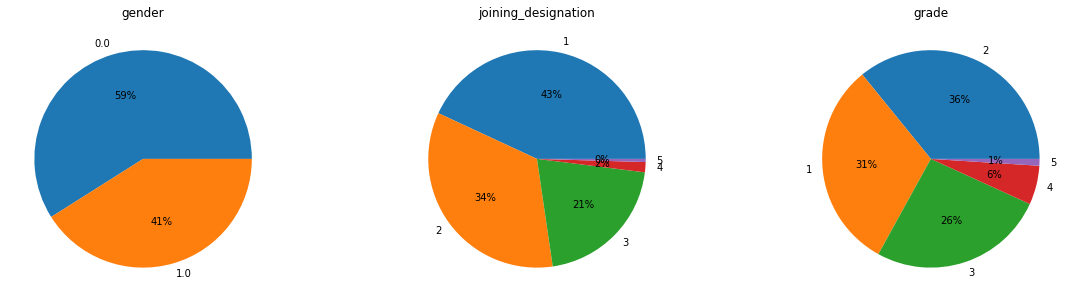

In [ ]:
cols = ['gender', 'joining_designation', 'grade']
plt.figure(figsize=(20,5))
for i,c in enumerate(cols):
  plt.subplot(1,3, i+1)
  plt.pie(df[c].value_counts(), autopct='%1.0f%%', labels = df[c].value_counts().index, radius = 1.0)
  plt.title(c)
plt.show()

1. 59% of drivers are males, 41% are females.
2. 43% drivers joined at designation 1, 34% at 2, 21% at 3 and 2% at 4.

Majority of drivers do not get a higher designation upon joining, but their designation might change over time, however the data for that is not provided. Which would've been a helping factor.

3. Grade 2 is very common, after that grades 1 and 3. These could be based on the income level, ages or business profits/losses brought by the drivers.



In [ ]:
cat = [c for c in df.columns if df[c].nunique()<=100]
cont = [c for c in df.columns if df[c].nunique()>100]

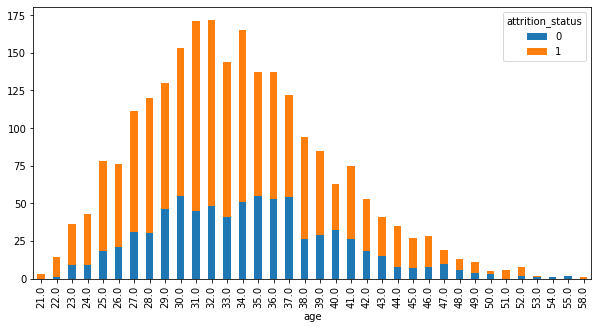

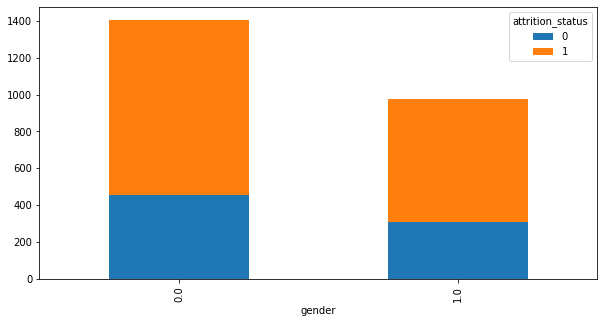

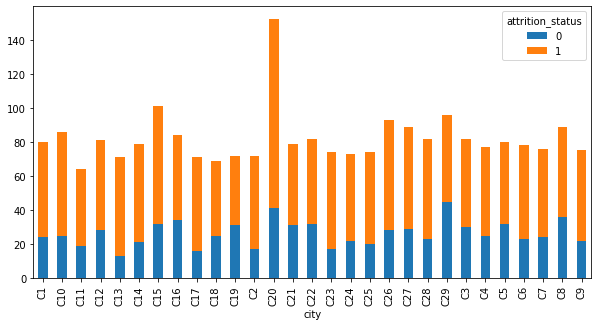

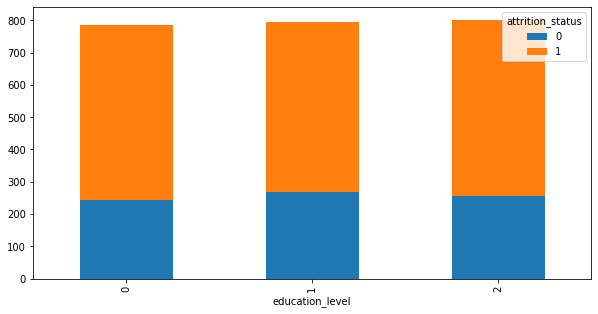

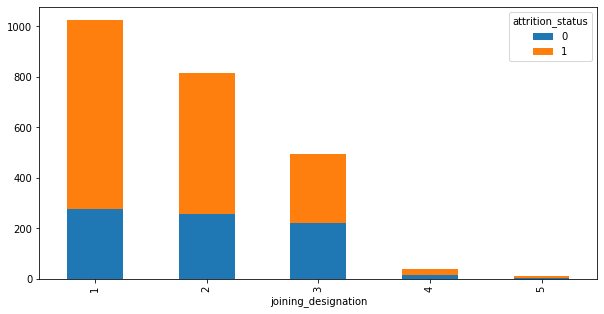

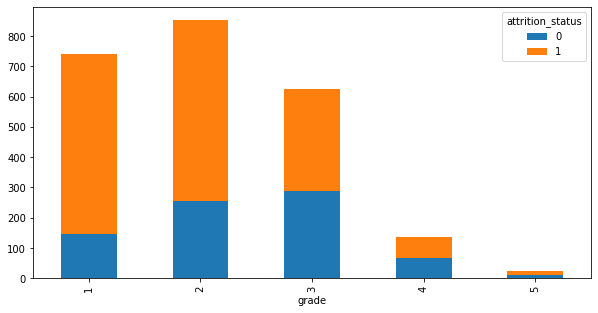

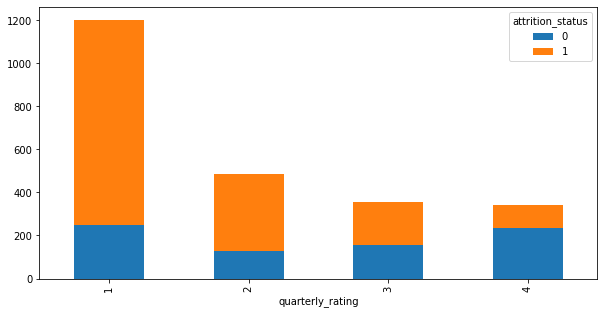

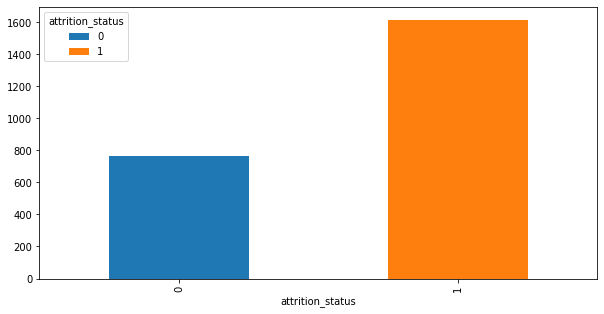

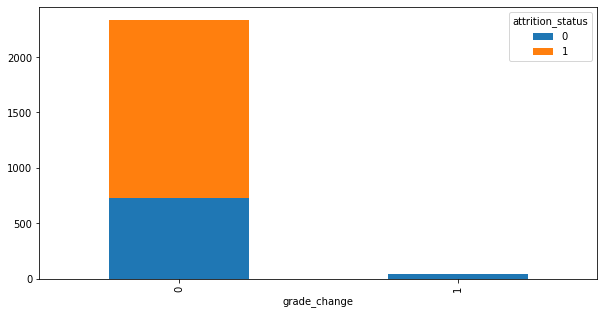

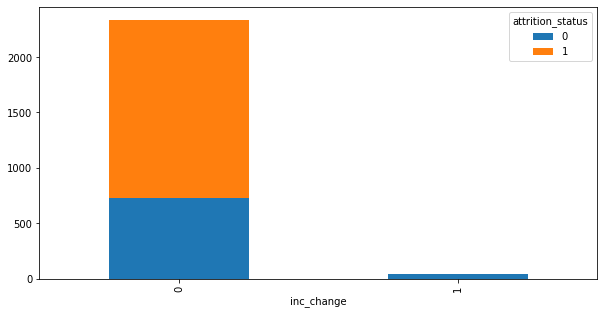

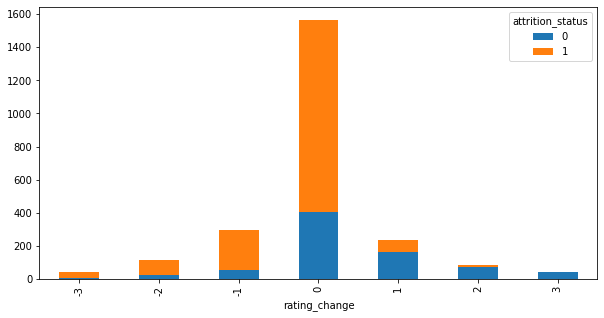

In [ ]:
for i,c in enumerate(cat):
  pd.crosstab(df[c], df['attrition_status']).plot(kind='bar', stacked=True, figsize=(10,5))
plt.show()

In [ ]:
df['attrition_status'].value_counts()

1    1616
0     765
Name: attrition_status, dtype: int64

Firstly, from the attrition status plot we can see, the number of drivers who have left the platform are twice the ones who stayed back. So, the data is highly imbalanced. Which needs to be balanced before model building.

Feature wise:
1. Age: There is a high ratio of attrition to non-attrition for drivers in the age group of 29 to 37. At 38 there is a suddent drop and then a further reducing tail with respect to drivers who leave the platform. A similar characteristic is observed below 29 years. 

For driver aged>=38, they might be requiring more stability so choose to not switch careers and continue with the service to support their families.

While for drivers aged<=28, they might just be starting out and feel they need more time to adjust into the platform and gain experience which is why they choose to stay probably at lower incomes.

Experienced candidates between 29-37 might have experience and more opportunities so they are ready to take some risks and leave earlier.

2. Gender: Males are more likely to leave compared to females based on the shown ratio. 

3. Most number of drivers come from cities C29 and C20. Highest attrition to non-attrition ratio is for C20. Target encoding is the best option for this feature.

4. There are equal ratios of attrition to non-attrition as well equal number of drivers across all education levels. Slightly higher number are observed for level 2.

5. Designations 1,2 and 3 have the highest numbers in the same order. But the attrition ratio is very high for 1, then for 2 and further for others, while the non attrition rates are almost similar for 1,2 and 3. 

6. Grade 2 and 1 have the highest attrition rate and most number of drivers in the same order. 3 has the highest non-attrition numbers and almost equal ratio.

7. Max quarterly rating 1 and 4 have the same numbers for non-attrition. But 1 has much much higher percentage of drivers who left the platform than any other rating category. 3 has equivalent numbers for both target values. 

8. Majority of drivers did not see a grade change in their careers on the platform. Some who did, had a positive change and did not leave the platform at all.

9. Majority of drivers did not see a income change in their careers on the platform. Some who did, had a positive change and did not leave the platform at all.

10. Drivers who did see a positive change in their quarterly ratings, have much lower rate of attrition. While who saw negative rating changes have so much higher attrition rates. Almost all drivers who suffered a -3 change, left the platform.

All the observations are interpreted carefully keeping in mind that the data is imbalanced for attrition.

Target Encoding City variable

In [ ]:
city_dict = dict(df[df['attrition_status']==1]['city'].value_counts(normalize=True))
df['city'] = df['city'].map(city_dict)

EDA for continous variables

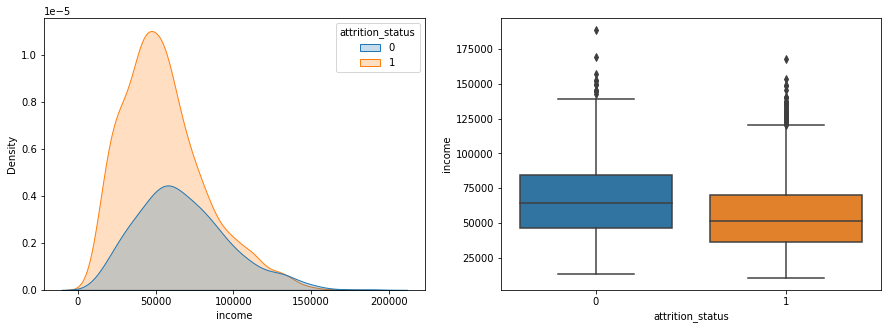

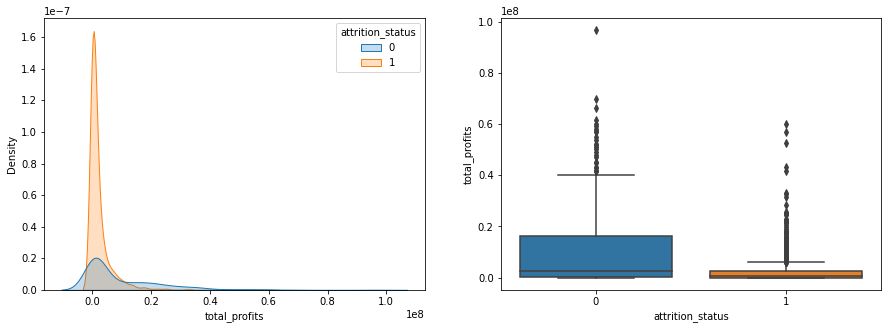

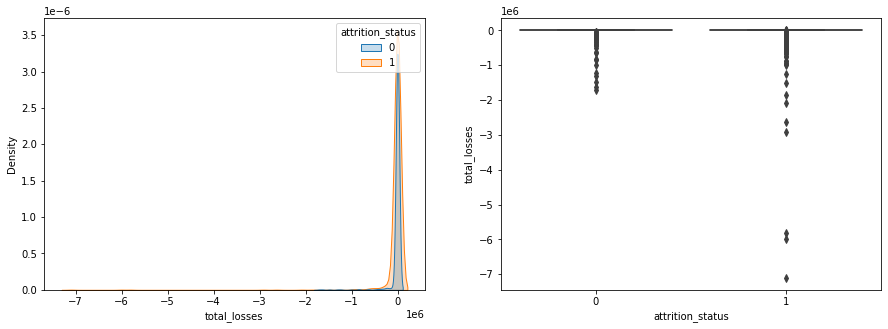

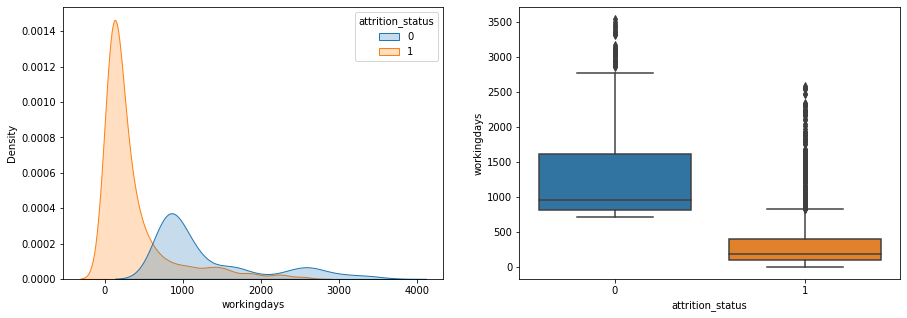

In [ ]:
for i,c in enumerate(cont):
  plt.figure(figsize=(15,5))
  plt.subplot(1,2, 1)
  sns.kdeplot(df[c], fill=True, hue=df['attrition_status'])
  plt.subplot(1,2, 2)
  sns.boxplot(y = df[c], x=df['attrition_status'])
plt.show()

1. Income: Average incomes for both target categories are close to 50k, both distributions are right skewed.

However, distribution for drivers who stayed is wider and has a smaller peak near 102k.

2. Drivers who attritioned saw almost no profits and there is a small tail where some did see close to 200k.

This tail is much smaller than non-attrition drivers which extend upto 800k profits. There is a smaller peak at 200k profits which slowly reduces to 400k.

So drivers who stayed, were more profitable for the company as a whole.

3. Most drivers did not see a lot of losses. However, the attrition curve has a very long tail beyond -600k losses while other category has a short one till -200k. 

4. Number of working days for drivers who left are very small compared to drivers who left. 

In [ ]:
cmaps = ['Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'mag']

[]

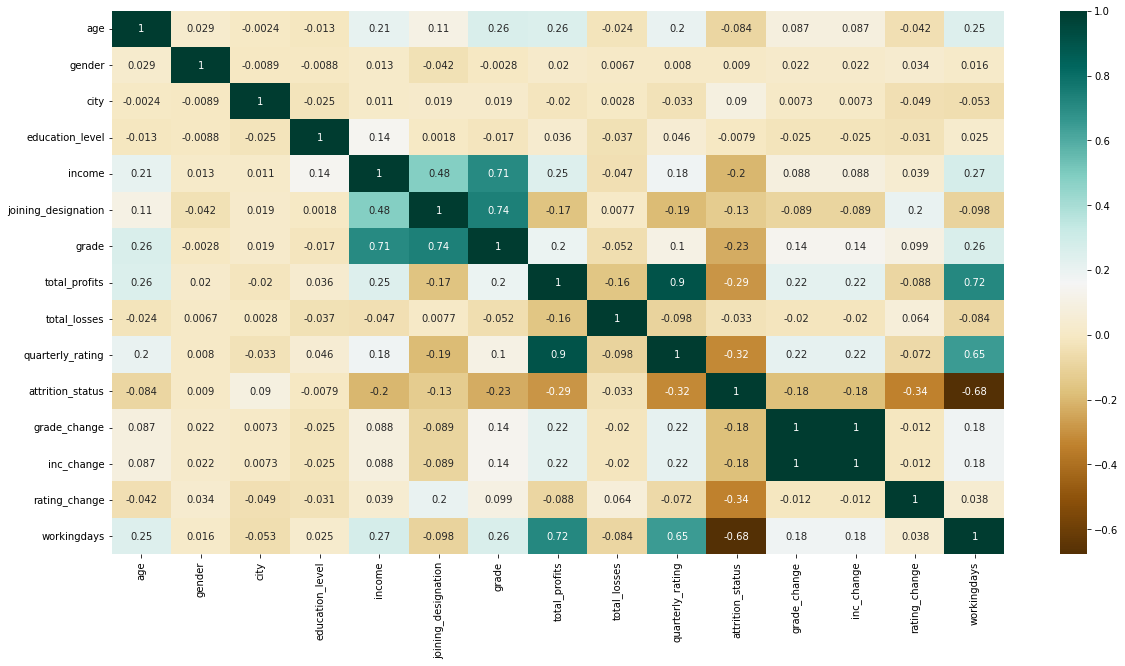

In [ ]:
plt.figure(figsize=(20,10))
sns.heatmap(df.corr(method='spearman'), cmap = cmaps[4], annot=True)
plt.plot()

Age, gender, city and education_level are the least related variables for our data as all other features have a >abs(0.1) correlation with the target.

Working days has the strongest correlations of -0.68, indicating that higher the working days for the driver, lower the chance of attrition.

Rating change is next strongest with -0.34, indicating higher the positive change in the rating, lower the chance of attrition.

Quarterly rating and total profits are also highly related with -0.32 and -0.29 in favour of non attrition.

Quarterly rating and total_profits have a very high 90% correlation, highest among all feature combinations.

total_profits are also impacted by working days, 0.72 indicates, there is a good 72% chance that with increase in working days, total profits of the company due to the driver will increase.

Higher aged drivers also experience higher profits as there is a 0.26 correlation.

Higher the joining designation, higher the income for the driver, we can see that due to the 0.48 correlation value.

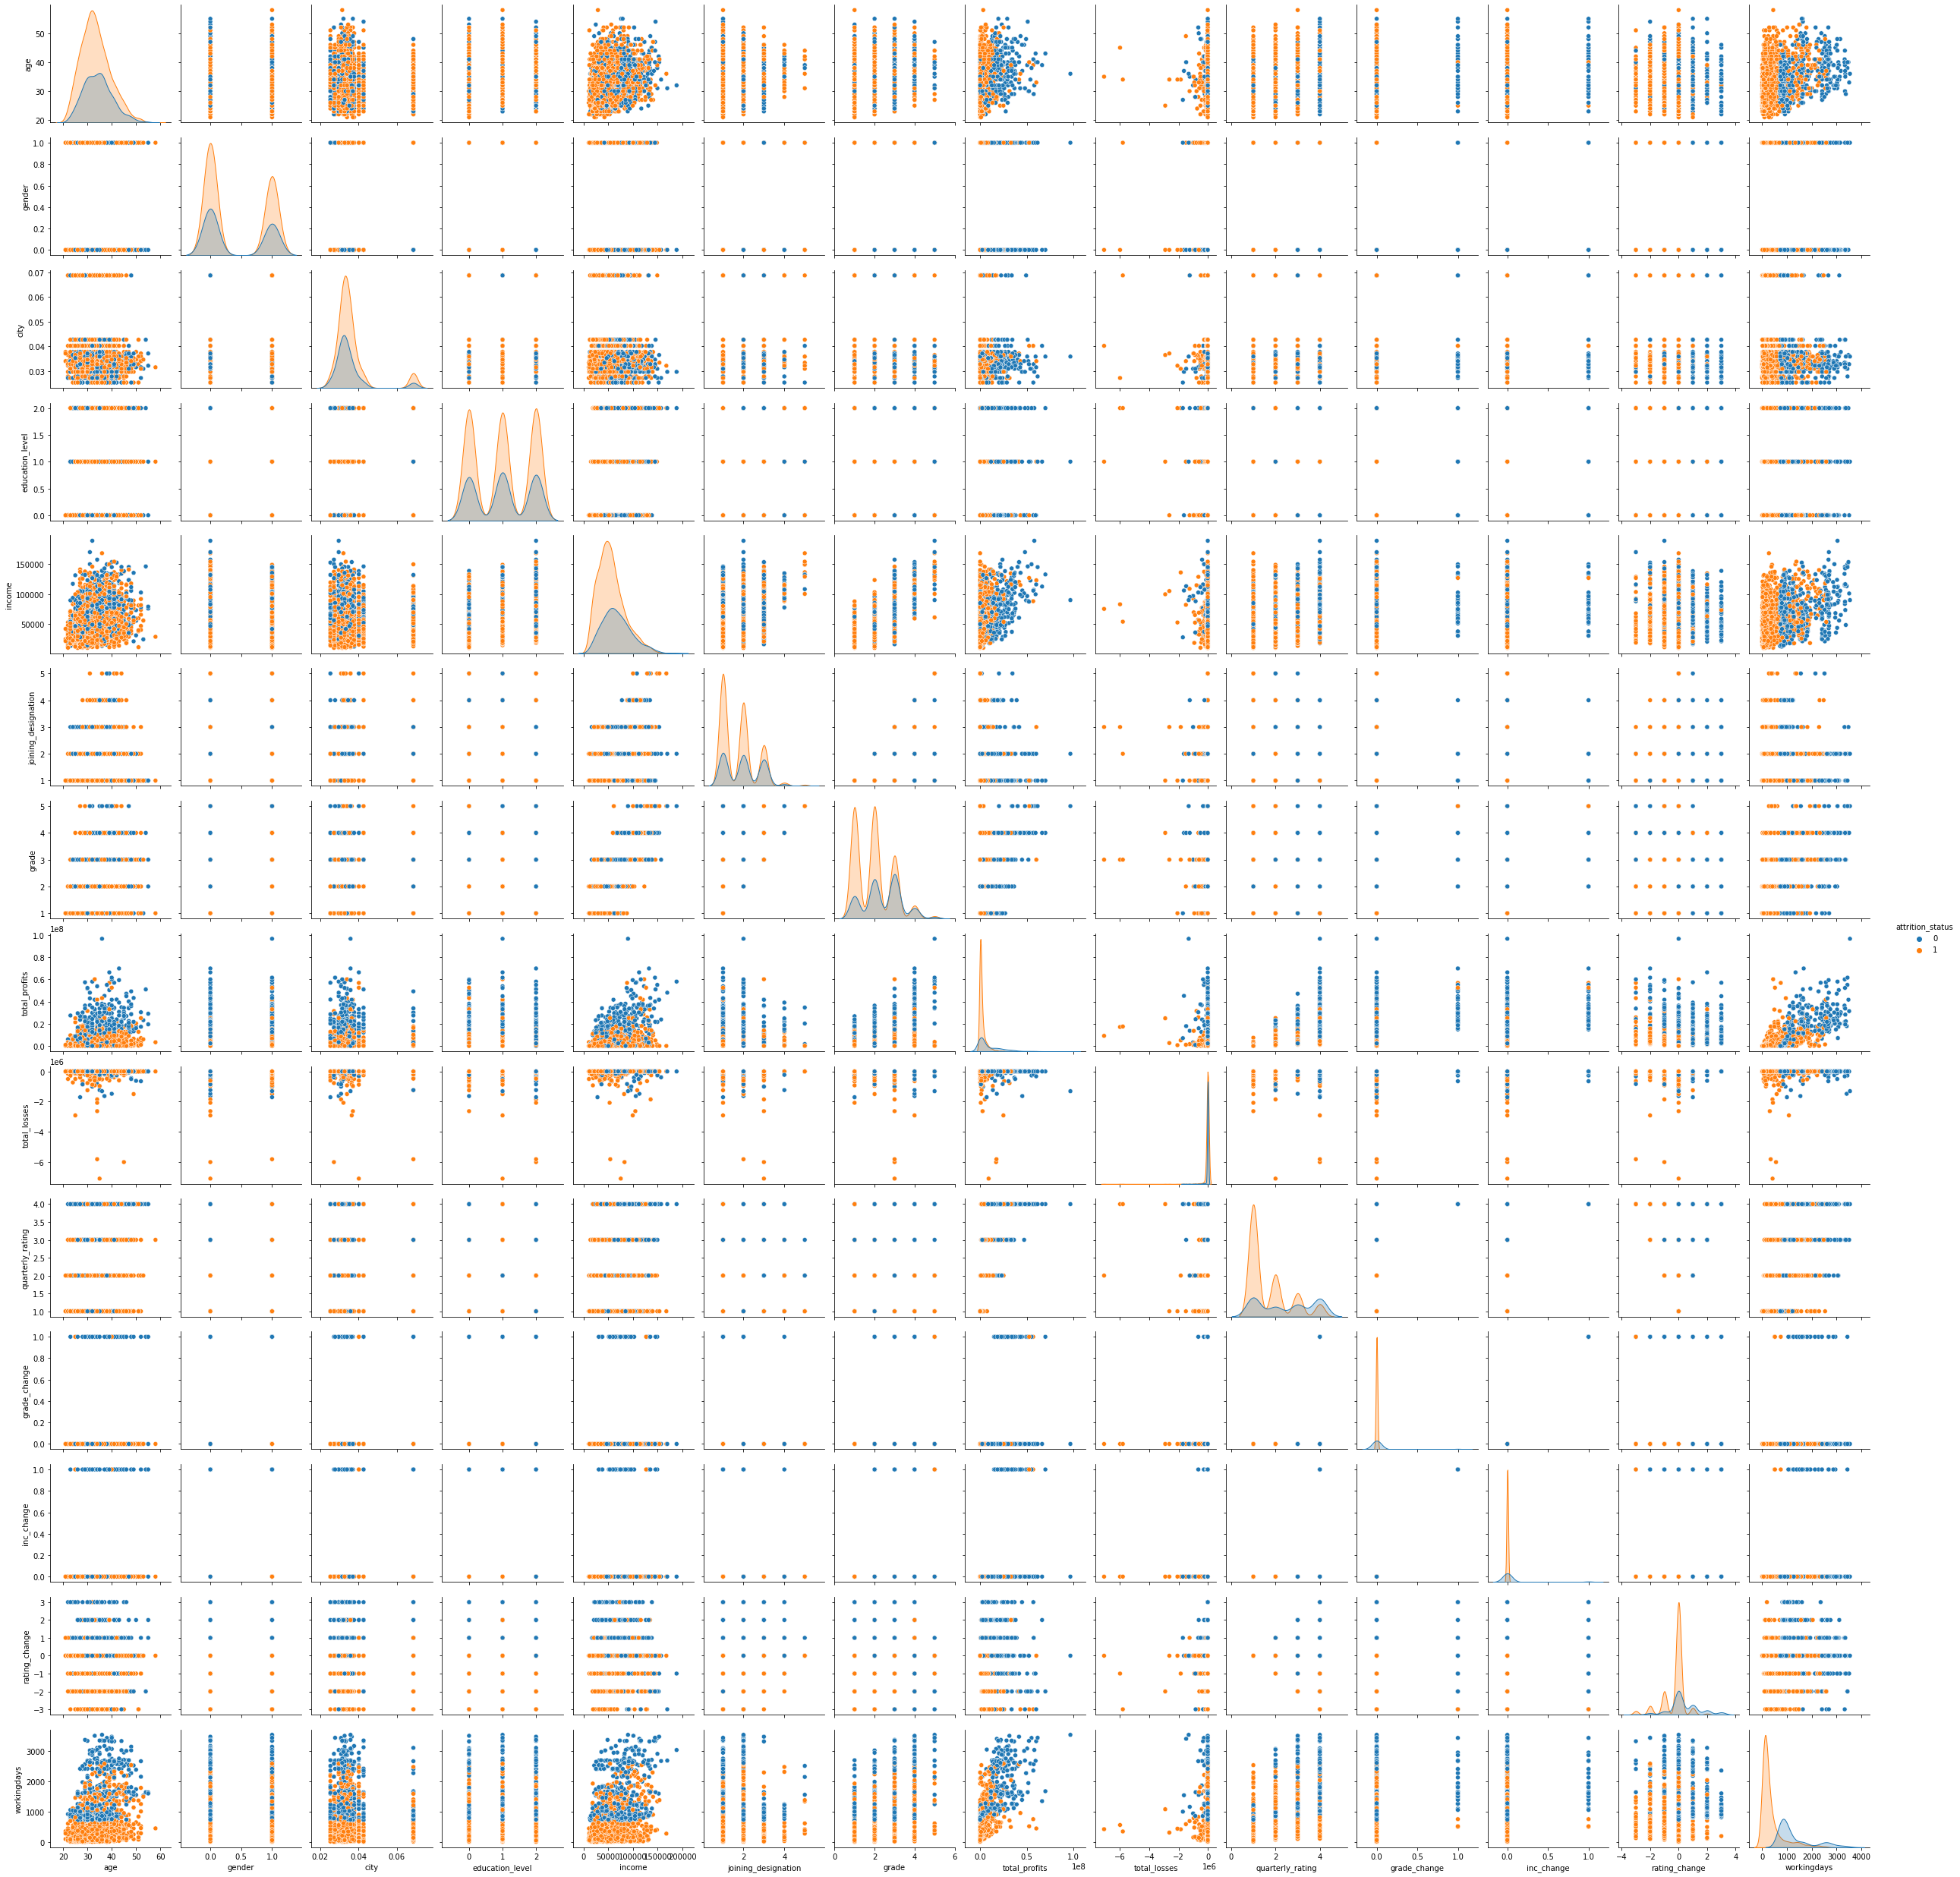

In [ ]:
sns.pairplot(data=df, hue='attrition_status')
plt.show()

1. Working days is a very good separator for our data to distinguish between drivers with possibilities of attrition and not. It is visible through plots of age, city and income. Multiple boundaries of this feature will help in decision trees. 

Doing a log transformation will help perform a F-test to determine if the feature is important.

2. Total_profits is a also a good splitter as visible in scatter plots with working days, income, city and age. This is a good indicator that if profits are close to 0, there is high chance of attrition.

Among the other important variables observed through EDA, these 2 are the ones which help in possible separation of the data visually through decision boundaries in univariate fashion. However in higher dimensions, other variables would definitely be very useful.

Let's do statistical selection of the variables.

In [ ]:
X = df.drop(columns = ['attrition_status'])
y = df['attrition_status']

In [ ]:
cat.pop(cat.index('attrition_status'))

'attrition_status'

In [ ]:
from scipy.stats import chi2_contingency
stats, pvals=[],[]
for c in cat:
  stat, p_val, _, _ = chi2_contingency(pd.crosstab(index = y, columns = X[c]))
  stats.append(stat)
  pvals.append(p_val)
ch2 = pd.DataFrame({'test_statistic':stats, 'p_val':pvals}, index = cat)
relevant_features = ch2[ch2['p_val']<0.05].index.values
print('relevant features are: ', relevant_features)
ch2

relevant features are:  ['age' 'city' 'joining_designation' 'grade' 'quarterly_rating'
 'grade_change' 'inc_change' 'rating_change']


,test_statistic,p_val
age,68.365722,6.268193e-04
gender,0.154374,6.943903e-01
city,36.550498,5.993890e-03
education_level,1.525254,4.664394e-01
joining_designation,49.140539,5.457615e-10
grade,131.522930,1.839435e-27
quarterly_rating,312.719049,1.757198e-67
grade_change,71.647408,2.572999e-17
inc_change,71.647408,2.572999e-17
rating_change,416.208371,9.145467e-87


Now, we have selected the best categorical features based on the dependency of Attrition status on the variable. 

Next step is to select the continuous features.

For this the most appropriate selection criteria is a Anova F-test or F_classif.

Basically, an F-test analyzes how well the data is separated, based on a certain feature.

It analyzes this by seeing how far the class means are from the over mean of the variable and how less the variance is among the classes for the same variable. This is a good measure to indicate the separation of the target classes by the variable values.

But, most of our variables are right skewed, so a log or box-cox transformation needs to be done to perform the F-test, for which the assumption that Data is normally distributed should get satisfied.

Log transformation

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


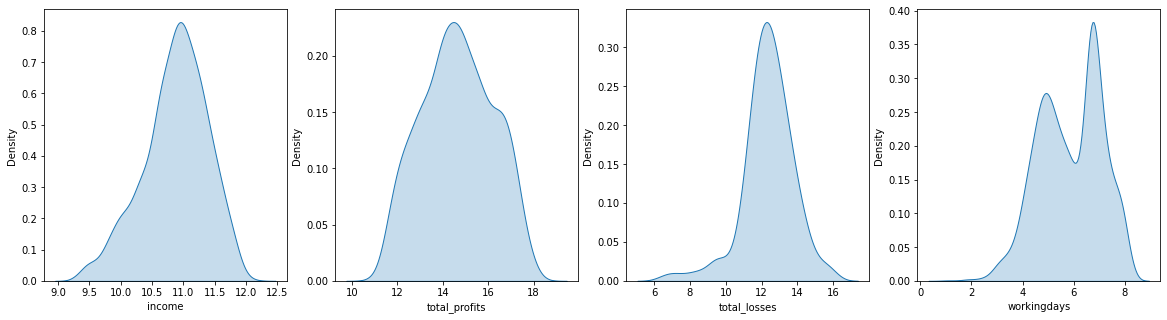

In [ ]:
plt.figure(figsize=(20,5))
for i,c in enumerate(cont):
  plt.subplot(1,len(cont), i+1)
  sns.kdeplot(np.log(np.abs(df[c])), fill=True)
plt.show()

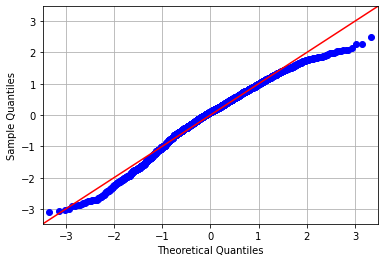

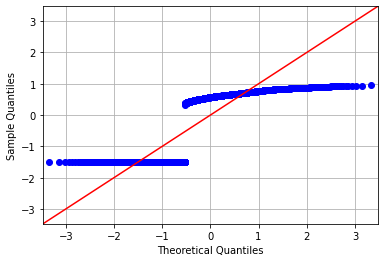

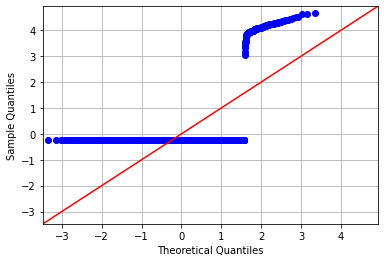

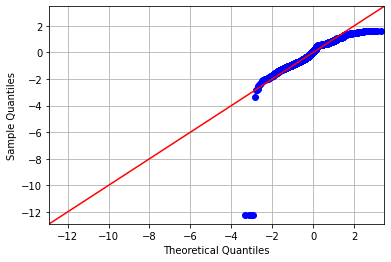

In [ ]:
import statsmodels.api as sm

for c in cont:
  fig = sm.qqplot(np.log(np.abs(df[c])+1e-5), line='45', fit=True)
  plt.grid()

The log transformation did not work as expected, we can now check with box cox transformation.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


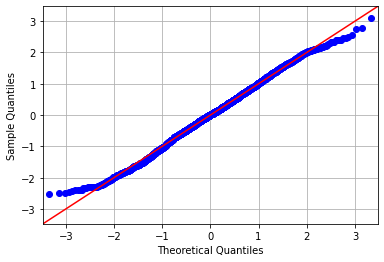

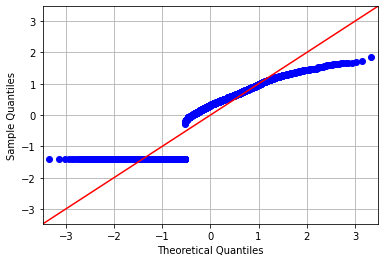

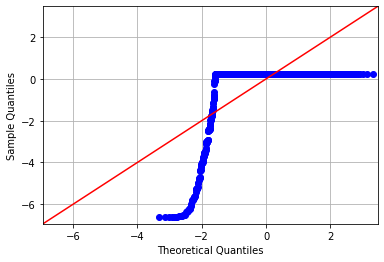

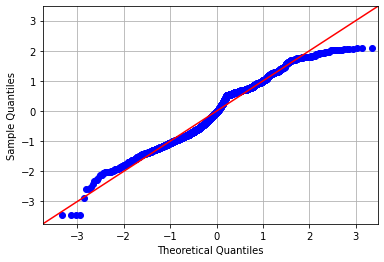

In [ ]:
from scipy import stats
X_t = X.copy()
for c in cont:
  if X_t[c].min()<=0: 
    X_t[c] = X_t[c]+abs(X_t[c].min())+1
  X_t[c], _ = stats.boxcox(X_t[c])
  fig = sm.qqplot(X_t[c], line='45', fit=True)
  plt.grid()

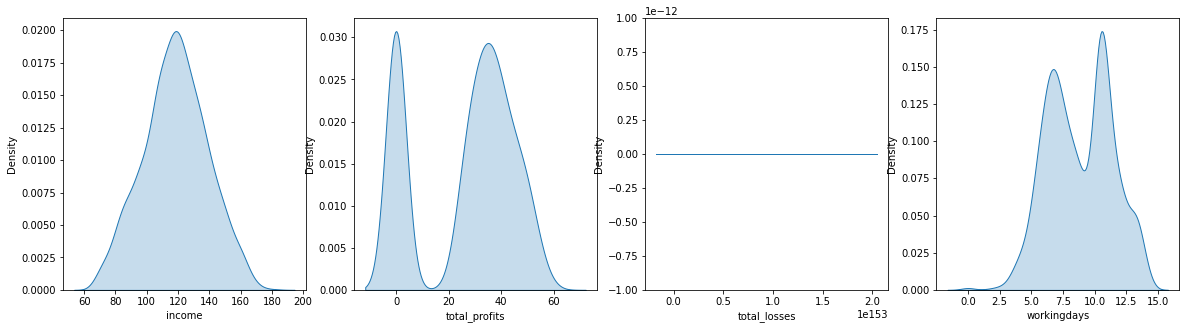

In [ ]:
plt.figure(figsize=(20,5))
for i,c in enumerate(cont):
  plt.subplot(1,len(cont), i+1)
  sns.kdeplot(X_t[c], fill=True)
plt.show()

Log-transformation worked better for our data, so lets continue using it.

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2, f_classif

kbest = SelectKBest(score_func=f_classif, k=3)
kbest.fit(np.log(np.abs(X[cont])+1e-5), y)

print(kbest.get_feature_names_out())
print(kbest.get_params())

['income' 'total_profits' 'workingdays']
{'k': 3, 'score_func': <function f_classif at 0x7f99c87413b0>}


In [ ]:
stats, pvals=[],[]
stats, pvals = f_classif(np.log(np.abs(X[cont])+1e-5), y)
f = pd.DataFrame({'test_statistic':stats, 'p_val':pvals}, index = cont)
relevant_features_c = f[f['p_val']<0.05].index.values
print('relevant features are: ', relevant_features_c)
f

relevant features are:  ['income' 'total_profits' 'workingdays']


,test_statistic,p_val
income,98.850902,7.546302e-23
total_profits,63.362071,2.637716e-15
total_losses,2.479388,1.154801e-01
workingdays,1278.549043,1.770478e-224


We see that manual F-test and SelectKBest both give the same results, so we can drop total_losses variable.

While we saw for higher losses drivers did tend towards leaving, this test indicates that the values towards the left tail of the distribution which showed tendency of attrition were outliers, but considering the overall normal population, this variable did not have much significance for the target variable.

In [ ]:
rel_feat = list(relevant_features)+list(relevant_features_c)
X = X[rel_feat]

Now that our data preprocessing, analysis and feature creation steps are complete, lets move onto model building

In [ ]:
X.shape

(2381, 11)

## Model Building

### Data Splitting

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 45)

### Descriptive Statistics for train data

In [ ]:
X_train.describe()

,age,city,joining_designation,grade,quarterly_rating,grade_change,inc_change,rating_change,income,total_profits,workingdays
count,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1.904000e+03,1904.000000
mean,33.668592,0.035867,1.808298,2.082983,1.922269,0.018908,0.018908,-0.055672,58879.329832,4.513296e+06,662.980042
std,6.021676,0.009541,0.835066,0.934224,1.108060,0.136234,0.136234,0.921541,28119.318296,8.732666e+06,707.269281
min,21.000000,0.025371,1.000000,1.000000,1.000000,0.000000,0.000000,-3.000000,10747.000000,0.000000e+00,0.000000
25%,29.000000,0.031559,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,38565.500000,0.000000e+00,129.000000
50%,33.000000,0.033416,2.000000,2.000000,1.000000,0.000000,0.000000,0.000000,54767.000000,8.052900e+05,377.500000
75%,37.000000,0.036510,2.000000,3.000000,3.000000,0.000000,0.000000,0.000000,75475.000000,4.224170e+06,900.500000
max,58.000000,0.068688,5.000000,5.000000,4.000000,1.000000,1.000000,3.000000,167758.000000,6.986790e+07,3504.000000


From the above table, only workingdays has outliers which might be drivers who have worked very long.

We saw that earliest dateofjoining years were 2013, so such values are possible and might affect if drivers are prone to attrition. So we can keep these outliers.

### Oversampling training data

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler

normalize = MinMaxScaler()
X_sm = normalize.fit_transform(X_train)

sm = SMOTE(random_state=5)
X_sm, y_sm = sm.fit_resample(X_sm, y_train)

X_sm = pd.DataFrame(normalize.inverse_transform(X_sm), columns = X_train.columns)
y_sm = pd.Series(y_sm)

for c in ['joining_designation', 'grade', 'quarterly_rating', 'grade_change', 'inc_change', 'rating_change', 'workingdays']:
  X_sm[c] = np.round(X_sm[c],0)

y_sm.value_counts()

0    1291
1    1291
Name: attrition_status, dtype: int64

### Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate

dt = DecisionTreeClassifier(max_depth = 6, min_samples_split=10, random_state=45, class_weight = 'balanced')
scores = cross_validate(dt, X_train, y_train, cv=5, return_train_score=True, scoring='accuracy')
print('Training Scores ', np.mean(scores['train_score']), ' Validation Score: ', np.mean(scores['test_score']))

Training Scores  0.9764972090241839  Validation Score:  0.9574595938665562


The scoring obtained with a Decision Tree classifier is very good. 97% training accuracy and 95.7% validation are appropriate for any application, but here now we need to check for classification metrics to be sure, as our data is imbalanced.

The Decision Tree model is definitely overfitting and needs to be more generalized as there is a 2% difference in Training and Validation Scores.

In [ ]:
from sklearn.metrics import classification_report

dt.fit(X_train, y_train)

y_pred = dt.predict(X_train)

print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96       613
           1       1.00      0.97      0.98      1291

    accuracy                           0.98      1904
   macro avg       0.97      0.98      0.97      1904
weighted avg       0.98      0.98      0.98      1904



For our application, we would wish to maximize recall as it is important to not miss drivers that are possibly going to leave the platform. 

This is important because then the company can incentivize these drivers.

If we prioritize precision, this would indicate we are trying to reduce number of predictions for drivers that are predicted as prone to attrition but actually don't. This would only lead to company incentivizing extra number of drivers which can be afforded only to a certain extent. However, losing drivers is going to hamper more availability of cabs for customers and therefore overall Ola profits.

So, recall is definitely more important and precision is also important but can be lowered if recall can increase.

### Random Forests

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 100, max_depth=6, min_samples_split=10, class_weight='balanced')
scores = cross_validate(rf, X_train, y_train, cv=5, return_train_score=True, scoring='recall')
print('Training Scores ', np.mean(scores['train_score']), ' Validation Score: ', np.mean(scores['test_score']))

Training Scores  0.9531371710304148  Validation Score:  0.9372571907455629


The Random Forest model is providing relatively lower scores with 100 n_estimators and other parameters. To improve recall, lets perform Hyperparameter Tuning.

In [ ]:
params = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [6, 10, 15, 20],
    'min_samples_split': [2, 5, 10, 20], 
    'max_features':[5,7,9,11],
    'class_weight' : ['balanced']
}

In [ ]:
%%timeit -r3

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

rf1 = RandomForestClassifier(random_state=45)

rcv = RandomizedSearchCV(rf1, param_distributions = params, scoring = 'recall')

rcv.fit(X_train, y_train)

rff = rcv.best_estimator_

print('Best Score: ', rcv.best_score_, ' Best Parameters: ', rcv.best_params_)

Best Score:  0.972895154290503  Best Parameters:  {'n_estimators': 200, 'min_samples_split': 2, 'max_features': 5, 'max_depth': 15, 'class_weight': 'balanced'}
Best Score:  0.9713507527461015  Best Parameters:  {'n_estimators': 200, 'min_samples_split': 2, 'max_features': 11, 'max_depth': 20, 'class_weight': 'balanced'}
Best Score:  0.9697973721229534  Best Parameters:  {'n_estimators': 100, 'min_samples_split': 2, 'max_features': 7, 'max_depth': 10, 'class_weight': 'balanced'}
Best Score:  0.9705755589476519  Best Parameters:  {'n_estimators': 150, 'min_samples_split': 5, 'max_features': 9, 'max_depth': 20, 'class_weight': 'balanced'}
18.6 s ± 2.04 s per loop (mean ± std. dev. of 3 runs, 1 loop each)


Best Score obtained is 0.973 for the parameters shown above in 1st line

Using the best parameters for building the model:

In [ ]:
rff = RandomForestClassifier(n_estimators = 200, max_depth=15, min_samples_split=2, max_features = 5, class_weight='balanced')
scores = cross_validate(rff, X_train, y_train, cv=5, return_train_score=True, scoring='recall')
print('Training Scores ', np.mean(scores['train_score']), ' Validation Score: ', np.mean(scores['test_score']))

Training Scores  1.0  Validation Score:  0.9721199604920535


With hyper parameter tuning we were able to drastically improve our training score from 95% to 100% recall and validation score from 94% to 97.4% recall.

This is a very well fitted model with slight overfitting. Let's try fitting this model with balanced data instead of class_weights.

In [ ]:
rff1 = RandomForestClassifier(n_estimators = 100, max_depth=20, min_samples_split=2, max_features = 5)
scores = cross_validate(rff, X_sm, y_sm, cv=5, return_train_score=True, scoring='recall')
print('Training Scores ', np.mean(scores['train_score']), ' Validation Score: ', np.mean(scores['test_score']))

Training Scores  1.0  Validation Score:  0.9659214031307055


There is a 1% drop in validation recall score for the model with balanced data. So, using class_weights is a better option for the model which we can continue with.

In [ ]:
rff.fit(X_train, y_train)
y_pred = rff.predict(X_train)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       613
           1       1.00      1.00      1.00      1291

    accuracy                           1.00      1904
   macro avg       1.00      1.00      1.00      1904
weighted avg       1.00      1.00      1.00      1904



From the above observations, we can conclude that this is an ideal model, but this is happening due to extremely good and strict feature selection criteria. However, the validation scores are not as good as the above report depicts.

Let's test the final Randomforest model with test data

In [ ]:
print('Test Score: ', rff.score(X_test, y_test))

ypred = rff.predict(X_test)

print(classification_report(y_test, ypred))

Test Score:  0.9853249475890985
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       152
           1       1.00      0.98      0.99       325

    accuracy                           0.99       477
   macro avg       0.98      0.99      0.98       477
weighted avg       0.99      0.99      0.99       477



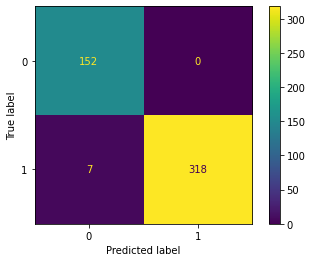

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, ypred)

ConfusionMatrixDisplay(cm).plot()

From the above confusion matrix we can observe that the model is able to produce very good predictions for drivers who can attrition and those who won't. 

However, the model is still prediction false negatives or missing some possible drivers who have actually left the platform. This needs to be improved to improve our recall score.

Feature Importances

In [ ]:
pd.DataFrame(rff.feature_importances_, index = rff.feature_names_in_, columns=['Importances']).T

,age,city,joining_designation,grade,quarterly_rating,grade_change,inc_change,rating_change,income,total_profits,workingdays
Importances,0.019188,0.013708,0.023339,0.021888,0.028292,0.001032,0.000944,0.080112,0.021703,0.082436,0.707358


1. Workingdays is most important feature for a Randomforest classifier with Average normalized information gain of 0.707

2. Total_profits is the second most important feature with IG of 0.082 then rating change with 0.8011

Let's see ROC-AUC curve for threshold selection.

#### ROC-AUC Curve

In [ ]:
y_probs = rff.predict_proba(X_test)[:,1]
dfx = pd.DataFrame({'y': y_test.values, 'prob':y_probs})
dfx = dfx.sort_values(by='prob', ascending=False, ignore_index=True)

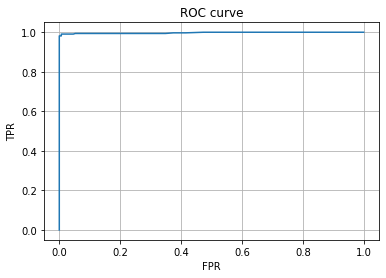

AUC score is:  0.9973076923076923


In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
fprl, tprl, thr = roc_curve(dfx.y, dfx.prob, drop_intermediate=True)

plt.plot(fprl, tprl)
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.grid()
plt.show()

print('AUC score is: ', roc_auc_score(dfx.y, dfx.prob))

At present, as per ROC-AUC score, our model is best for test data and training data. As the selection threshold can be anything close to 1 for predicting 1 and close to 0 for class 0.

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

def roc_auc(model, X_test, y_test):
  y_probs = model.predict_proba(X_test)[:,1]
  dfx = pd.DataFrame({'y': y_test.values, 'prob':y_probs})
  dfx = dfx.sort_values(by='prob', ascending=False, ignore_index=True)

  fprl, tprl, thr = roc_curve(dfx.y, dfx.prob, drop_intermediate=True)

  plt.plot(fprl, tprl)
  plt.title('ROC curve')
  plt.xlabel('FPR')
  plt.ylabel('TPR')
  plt.grid()
  plt.show()

  print('AUC score is: ', roc_auc_score(dfx.y, dfx.prob))

## Gradient Boosting

In [ ]:
%%timeit -r1
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(random_state=45, subsample=0.8, min_samples_split=10, max_depth=3, max_features = 'sqrt')
scores = cross_validate(gbc, X_train, y_train, cv=5, return_train_score=True, scoring='recall')
print('Training Scores ', np.mean(scores['train_score']), ' Validation Score: ', np.mean(scores['test_score']))

Training Scores  0.9852825742737717  Validation Score:  0.9682469845260542
Training Scores  0.9852825742737717  Validation Score:  0.9682469845260542
776 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Gradient boosted classifier with unbalanced data is giving better scores than the initial RandomforestsClassifier model with class weights.

Training score of 0.985 and validation 0.96825 has less than 2% difference which is very good. 

Let's try with balanced data.

##### With Balanced Data

In [ ]:
%%timeit -r1
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(random_state=45, subsample=0.8, min_samples_split=10, max_depth=3, max_features = 'sqrt')
scores = cross_validate(gbc, X_sm, y_sm, cv=5, return_train_score=True, scoring='recall')
print('Training Scores ', np.mean(scores['train_score']), ' Validation Score: ', np.mean(scores['test_score']))

Training Scores  0.9740508941368933  Validation Score:  0.9519888659423543
Training Scores  0.9740508941368933  Validation Score:  0.9519888659423543
1.11 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [ ]:
gbc.fit(X_sm, y_sm)
y_pred = rff.predict(X_sm)
print(classification_report(y_sm, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1291
           1       1.00      1.00      1.00      1291

    accuracy                           1.00      2582
   macro avg       1.00      1.00      1.00      2582
weighted avg       1.00      1.00      1.00      2582



#### Hyperparameter Tuning for Balanced data Model

In [ ]:
%%timeit -r1

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

params = {
    'n_estimators': [50, 100, 150, 200, 300],
    'max_depth': [2, 3, 5, 10],
    'min_samples_split': [2, 5, 10, 20], 
    'max_features':[2,3,4,5],
    'subsample': list(np.arange(0.5, 0.9, 0.1)),
    'ccp_alpha': list(np.arange(0,1, 0.5)),
    'learning_rate': list(np.arange(0.1, 1))
}

gbc = GradientBoostingClassifier(random_state=45)

rscv = RandomizedSearchCV(gbc, param_distributions = params, scoring = 'recall', error_score='raise')

rscv.fit(X_sm, y_sm)

gbcf = rscv.best_estimator_

print('Best Score: ', rscv.best_score_, ' Best Parameters: ', rscv.best_params_)

Best Score:  1.0  Best Parameters:  {'subsample': 0.7999999999999999, 'n_estimators': 150, 'min_samples_split': 20, 'max_features': 2, 'max_depth': 2, 'learning_rate': 0.1, 'ccp_alpha': 0.5}
Best Score:  0.9659214031307055  Best Parameters:  {'subsample': 0.7, 'n_estimators': 150, 'min_samples_split': 10, 'max_features': 2, 'max_depth': 5, 'learning_rate': 0.1, 'ccp_alpha': 0.0}
15.5 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Training GBDT with the best parameters. 

We've got 2 sets of best parameters, let's choose the one with lesser complexity. 

    {'subsample': 0.8, 'n_estimators': 150, 'min_samples_split': 20, 'max_features': 2, 'max_depth': 2, 'learning_rate': 0.1, 'ccp_alpha': 0.5}

In [ ]:
gbcf = GradientBoostingClassifier(random_state=45, subsample= 0.7, n_estimators= 150, min_samples_split= 10, max_features= 2, max_depth= 5, ccp_alpha= 0.0)

scores = cross_validate(gbcf, X_sm, y_sm, cv=5, return_train_score=True, scoring='recall')
print('Training Scores ', np.mean(scores['train_score']), ' Validation Score: ', np.mean(scores['test_score']))

gbcf.fit(X_sm, y_sm)
y_pred = gbcf.predict(X_sm)
print(classification_report(y_sm, y_pred))

Training Scores  0.9996127783155856  Validation Score:  0.9659214031307055
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1291
           1       1.00      1.00      1.00      1291

    accuracy                           1.00      2582
   macro avg       1.00      1.00      1.00      2582
weighted avg       1.00      1.00      1.00      2582



The validation score increased by 1.5%, while the training score reached very close to 1. But there is still a 2.5% difference in both scores, which can be reduced by more advanced algos like XGBoost or LightGBM. The General GBDT currently is slightly overfit.

Let's see the results on test_data

On test data

              precision    recall  f1-score   support

           0       0.92      1.00      0.96       152
           1       1.00      0.96      0.98       325

    accuracy                           0.97       477
   macro avg       0.96      0.98      0.97       477
weighted avg       0.97      0.97      0.97       477



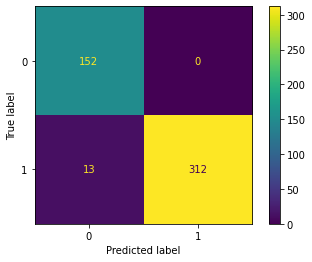

In [ ]:
ypred = gbcf.predict(X_test)
print(classification_report(y_test, ypred))

cm = confusion_matrix(y_test, ypred)

ConfusionMatrixDisplay(cm).plot()

ROC-AUC characteristics.

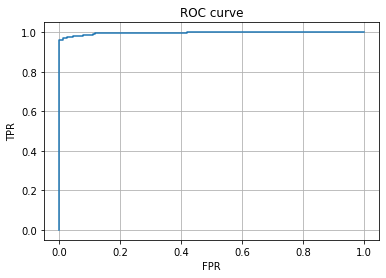

AUC score is:  0.9963360323886641


In [ ]:
roc_auc(gbcf, X_test, y_test)

Here we see, that there is an increase in False negative predications, which reduces our recall. So, for our application general GBDT Classifier is not as good as a well tuned RandomForest Classifier algorithm.

The reason being, that deep trees in a Randomforest classifier are overfitting on the data and producing alot of separating lines for our complicated data. This produces higher variance which is handled by RandomForest by aggregation. Using Class_weights and not balanced data is also helping as the initial data was somewhat separable across features but dummy data product by oversampling might complicate things.

Class weights parameter can help a Decision tree select features by enforcing balancing weights on the Gini or Entropy impurities thus providing correct estimations for the information gain out a feature based node. 

However, it's possible that in General GBDT, where we have to use balanced data, because class weights cannot be assigned in the implementation, the dummy data created for class 0 is leading to crowding in the usual axis thus leading to decision boundaries being further apart. So, when the test data is introduced, the boundaries are slightly different from RandomForest DTs and give a lower overall score by misclassifying some possible drivers who attrition.

There are definite outliers in the data which can be part of the test data as well, so these cannot be very specifically classified correctly. But the models are doing a very good overall job, just RandomForest is performing better with lesser data.

Feature Importances

In [ ]:
pd.DataFrame(gbcf.feature_importances_, index = gbcf.feature_names_in_, columns=['Importances']).T

,age,city,joining_designation,grade,quarterly_rating,grade_change,inc_change,rating_change,income,total_profits,workingdays
Importances,0.020399,0.014661,0.032207,0.028491,0.055646,0.003338,0.004419,0.070536,0.029014,0.084139,0.65715


A similar result to RF model observed for feature importances

### XGBoost

In [ ]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from xgboost import XGBClassifier

xgb = XGBClassifier(random_state=45, n_estimators=100, subsample=0.8, min_samples_split=10, max_depth=3, max_features = 'sqrt')
scores = cross_validate(xgb, X_sm, y_sm, cv=5, return_train_score=True, scoring='recall')
print('Training Scores ', np.mean(scores['train_score']), ' Validation Score: ', np.mean(scores['test_score']))

Training Scores  0.9761826770826298  Validation Score:  0.9589566310496543


Initial Results are only 0.6% better than a Generic GBDT

#### Hyperparameter Tuning

In [ ]:
%%timeit -r1

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

params = {
    'n_estimators': [50, 100, 150, 200, 300],
    'max_depth': [2, 3, 5, 10],
    'min_samples_split': [2, 5, 10, 20], 
    'max_features':[2,3,4,5],
    'subsample': list(np.arange(0.5, 0.9, 0.1)),
    'ccp_alpha': list(np.arange(0,1, 0.5)),
    'learning_rate': list(np.arange(0.1, 1))
}

xgb = XGBClassifier(random_state=45)

xrscv = RandomizedSearchCV(gbc, param_distributions = params, scoring = 'recall', error_score='raise')

xrscv.fit(X_sm, y_sm)

xgbf = xrscv.best_estimator_

print('Best Score: ', xrscv.best_score_, ' Best Parameters: ', xrscv.best_params_)

Best Score:  0.9698003651492023  Best Parameters:  {'subsample': 0.7, 'n_estimators': 50, 'min_samples_split': 2, 'max_features': 3, 'max_depth': 10, 'learning_rate': 0.1, 'ccp_alpha': 0.0}
Best Score:  0.9667025829816527  Best Parameters:  {'subsample': 0.6, 'n_estimators': 200, 'min_samples_split': 5, 'max_features': 3, 'max_depth': 3, 'learning_rate': 0.1, 'ccp_alpha': 0.0}
13.8 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Training Model with Best Parameters

In [ ]:
xgbf = XGBClassifier(random_state=45, n_estimators=50, subsample=0.7, min_samples_split=2, max_depth=10, max_features = 3, learning_rate=0.1)
scores = cross_validate(xgbf, X_sm, y_sm, cv=5, return_train_score=True, scoring='recall')
print('Training Scores ', np.mean(scores['train_score']), ' Validation Score: ', np.mean(scores['test_score']))

Training Scores  0.9916730453184449  Validation Score:  0.9682469845260542


There is only a 1% improvement from the initial model, while only 0.02% from GBDT.

Let's see Confusion matrix if the algorithm is performing well.

              precision    recall  f1-score   support

           0       0.92      1.00      0.96       152
           1       1.00      0.96      0.98       325

    accuracy                           0.97       477
   macro avg       0.96      0.98      0.97       477
weighted avg       0.97      0.97      0.97       477



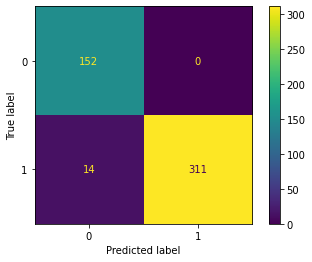

In [ ]:
xgbf.fit(X_sm, y_sm)
ypred = xgbf.predict(X_test)
print(classification_report(y_test, ypred))

cm = confusion_matrix(y_test, ypred)

ConfusionMatrixDisplay(cm).plot()

No improvements observed in reducing the False negatives.

Let's try LightGBM

### LightGBM

In [ ]:
!pip install lightgbm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from lightgbm import LGBMClassifier

lgb = LGBMClassifier(boosting_type='goss' ,random_state=45, n_estimators=100, subsample=0.8, min_child_samples=10, max_depth=3, colsample_bytree = 0.8, class_weight = 'balanced')
scores = cross_validate(lgb, X_train, y_train, cv=5, return_train_score=True, scoring='recall')
print('Training Scores ', np.mean(scores['train_score']), ' Validation Score: ', np.mean(scores['test_score']))

Training Scores  0.9761809886159826  Validation Score:  0.9597168597168597


Scores are similar to XGBoost and GBDT

#### Hyperparameter Tuning

In [ ]:
%%timeit -r1

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

params = {
    'n_estimators': [50, 100, 150, 200, 300],
    'max_depth': [2, 3, 5, 10],
    'min_child_samples': [2, 5, 10, 20], 
    'colsample_bytree':[0.8, 0.5,0.7,0.9],
    'subsample': list(np.arange(0.5, 0.9, 0.1)),
    'reg_alpha': list(np.arange(0,1, 0.5)),
    'learning_rate': list(np.arange(0.1, 1))
}

lgb = LGBMClassifier(random_state=45)

lrscv = RandomizedSearchCV(lgb, param_distributions = params, scoring = 'recall', error_score='raise')

lrscv.fit(X_sm, y_sm)

lgbf = lrscv.best_estimator_

print('Best Score: ', lrscv.best_score_, ' Best Parameters: ', lrscv.best_params_)

Best Score:  0.9674777767801024  Best Parameters:  {'subsample': 0.6, 'reg_alpha': 0.5, 'n_estimators': 150, 'min_child_samples': 20, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
Best Score:  0.9697973721229534  Best Parameters:  {'subsample': 0.6, 'reg_alpha': 0.0, 'n_estimators': 300, 'min_child_samples': 5, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 0.9}
6.25 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Training Model with Best parameters

In [ ]:
lgbf = LGBMClassifier(n_estimators = 300, max_depth=10, min_child_samples=5, colsample_bytree = 0.9, class_weight='balanced', reg_alpha=0, subsample=0.6)
scores = cross_validate(lgbf, X_train, y_train, cv=5, return_train_score=True, scoring='recall')
print('Training Scores ', np.mean(scores['train_score']), ' Validation Score: ', np.mean(scores['test_score']))

Training Scores  1.0  Validation Score:  0.9682439914998053


              precision    recall  f1-score   support

           0       0.93      0.99      0.96       152
           1       1.00      0.96      0.98       325

    accuracy                           0.97       477
   macro avg       0.96      0.98      0.97       477
weighted avg       0.97      0.97      0.97       477



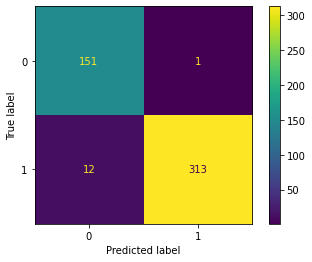

In [ ]:
lgbf.fit(X_sm, y_sm)
ypred = lgbf.predict(X_test)
print(classification_report(y_test, ypred))

cm = confusion_matrix(y_test, ypred)

ConfusionMatrixDisplay(cm).plot()

Again, performance is not observed to be as good as a RandomForest Ensemble model.

### Final Model Conclusions

So, we can conclude that our tuned Random Forest model with the parameters: 

    {'n_estimators': 200, 'min_samples_split': 2, 'max_features': 5, 'max_depth': 15, 'class_weight': 'balanced'}

Best Model Features are: 

1. Workingdays is most important feature for a Randomforest classifier with Average normalized information gain of 0.707

2. Total_profits is the second most important feature with IG of 0.082 then rating change with 0.8011

Best Obtained Testing Scores: 

In [ ]:
ypred = rff.predict(X_test)

from sklearn.metrics import precision_recall_fscore_support

prec,rec,fscore, _ = precision_recall_fscore_support(y_test, ypred)

print(f'Precision: {prec[1]}, Recall: {rec[1]}, F2 Score: {fscore[1]}, Accuracy: {rff.score(X_test, y_test)}')

Precision: 1.0, Recall: 0.9784615384615385, F2 Score: 0.9891135303265941, Accuracy: 0.9853249475890985


A Tuned Random Forest Model gave the best classifier model with really good reduction in False Negatives thus improving Recall scores.

Only 7 False positives or misclassified Attritioned drivers were predicted while everything else was correctly predicted as Attrition or Non-attrition.

## Business Insights

1. Firstly, the data belongs majorily to the years of 2019 and 2020, which were the most impacted by Covid 19, therefore, irrespective of the attributes, there are alot more drivers who left the platform during lockdowns and that is why the data was imbalanced towards drivers who attrition.

For developing a proper model, data from earlier years need to be shared to make a more generic model as the current model may turn out to be very accurate but there will be discrepancies in future as its criterias are very strict.

2. 50% of drivers are in the age group of 30 to 40.

99% of drivers are in the age group of 22 to 52.

3. Around 50% of drivers earn between 45k to 80k per month. 99% of total earn 22k to 1.5L.

4. Alot of drivers are operating are break even for the company. Very few provide a business value that is upwards of 50k for the company. However, there are also drivers causing losses of upwards of 5L for the company. 

Feature wise:

5. Age: There is a high ratio of attrition to non-attrition for drivers in the age group of 29 to 37. At 38 there is a sudden drop and then a further reducing tail with respect to drivers who leave the platform. 

A similar characteristic is observed below 29 years.
For driver aged>=38, they might be requiring more stability so choose to not switch careers and continue with the service to support their families.

While for drivers aged<=28, they might just be starting out and feel they need more time to adjust into the platform and gain experience which is why they choose to stay probably at lower incomes.

Experienced candidates between 29-37 might have experience and more opportunities so they are ready to take some risks and leave earlier.

6. Gender: Males are more likely to leave compared to females based on the ratio of total to attrition rate.

7. Most number of drivers come from cities C29 and C20. Highest attrition to non-attrition ratio is for C20. Target encoding was the best option for this feature.

8. There are equal ratios of attrition to non-attrition as well equal number of drivers across all education levels. Slightly higher number are observed for level 2.

9. Designations 1,2 and 3 have the highest numbers in the same order. But the attrition ratio is very high for 1, then for 2 and further for others, while the non attrition rates are almost similar for 1,2 and 3.

*Which indicates that drivers joining at lower designations are prone to leaving earlier given any sudden inconvenience. 

10. Grade 2 and 1 have the highest attrition rate and most number of drivers in the same order. 3 has the highest non-attrition numbers and almost equal ratio.

11. Max quarterly rating 1 and 4 have the same numbers for non-attrition. But 1 has much much higher percentage of drivers who left the platform than any other rating category. 3 has equivalent numbers for both target values.

12. Majority of drivers did not see a grade change in their careers on the platform. Some who did, had a positive change and did not leave the platform at all.

13. Majority of drivers did not see a income change in their careers on the platform. Some who did, had a positive change and did not leave the platform at all.

14. Drivers who did see a positive change in their quarterly ratings, have much lower rate of attrition. While who saw negative rating changes have so much higher attrition rates. Almost all drivers who suffered a -3 change, left the platform.

15. Income: Average incomes for both target categories are close to 50k, both distributions are right skewed.

However, distribution for drivers who stayed is wider and has a smaller peak near 102k.

16. Drivers who attritioned saw almost no profits and there is a small tail where some did see close to 200k.

This tail is much smaller than non-attrition drivers which extend upto 800k profits. There is a smaller peak at 200k profits which slowly reduces to 400k.

So drivers who stayed, were more profitable for the company as a whole.

17. Most drivers did not see a lot of losses. However, the attrition curve has a very long tail beyond -600k losses while other category has a short one till -200k. 

18. Number of working days for drivers who left are very small compared to drivers who left. 

19. Working days is a very good separator for our data to distinguish between drivers with possibilities of attrition and not. It is visible through plots of age, city and income. Multiple boundaries of this feature helped in decision trees. 

20. Total_profits is a also a good splitter as visible in scatter plots with working days, income, city and age. This is a good indicator that if profits are close to 0, there is high chance of attrition.

Among the other important variables observed through EDA, these 2 are the ones which help in possible separation of the data visually through decision boundaries in univariate fashion. However in higher dimensions, other variables would definitely be very useful.

## Recommendations:

1. As observed, drivers in the age group of 29-40 tend to leave as they can afford the risks. But beyond that age drivers do not switch for stablity in ride bookings and their incomes.

As working days was observed to be the most important factor in predicting employee attrition:

So, OLA can develop a temporary employee benefit program for drivers who have been with them for more than 3 years, so that drivers who are well experienced with the system can get higher incomes based on certain criteria like completing 6 months after 3 years or bonus schemes for drivers to move them into the prime categories. This will help drivers be motivated to stay with OLA for longer irrespective of their ages and can help onboard more younger drivers starting their careers.

2. There should be sharp check on drivers who join on Lower designations. Even after 1-2 years some drivers are not able to improve their designations or quarterly ratings. OLA should automate to red flag such drivers and if there is a discrepancy in their operational quality, OLA can start training and customer dealing programs for the drivers to help them mature and develop into better drivers.

3. Their is a very high probablity of leaving for drivers who led to losses for the company, this can be marked as a red flag for OLA. When drivers cross a certain threshold in their Profit to Loss for business value, OLA should either terminate the driver or investigate the operations to ensure better ride quality for customers thus improving the platform.

4. OLA should advertise onboarding of more Female drivers as they are less likely to leave and better gender ratios would make cabs safer for women to travel, thus increasing its profits and ride booking numbers.

5. Drivers who improve their incomes based on their joining dates are also less likely to leave, so such drivers should be incentivized by the company and OLA can help them with car care operations as their rating will increase profits based on car conditions.